<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/9_lenet_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/ML_class/2023/6_CNN')
%pwd

'/content/drive/MyDrive/Colab Notebooks/ML_class/2023/6_CNN'

# Convolutional Neural Networks: MNIST

In this notebook, you will:

- Implement helper functions that you will use when implementing a PyTorch model
- Implement a fully functioning ConvNet using PyTorch

**After this assignment you will be able to:**

- Build and train a ConvNet in PyTorch for a classification problem

We assume here that you are already familiar with PyTorch.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')

using device: cuda
Tesla T4
Memory usage:
Allocated: 0.0 MB


## 1. PyTorch model

### 1.1. Load dataset (MNIST)

Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call.

We will start by loading in the packages.

The MNIST Dataset is located at http://yann.lecun.com/exdb/mnist/. Each image has $28 \times 28$ dimension.

-train-images-idx3-ubyte.gz:  training set images (9912422 bytes) including 55000 examples <br>
-train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) <br>
-t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) including 10000 examples <br>
-t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [ ]:
train_dataset = datasets.MNIST( root='./mnist_data/',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)
test_dataset = datasets.MNIST( root='./mnist_data/',
                             train = False,
                             transform=transforms.ToTensor())

x.shape: torch.Size([1, 28, 28])
label: 5


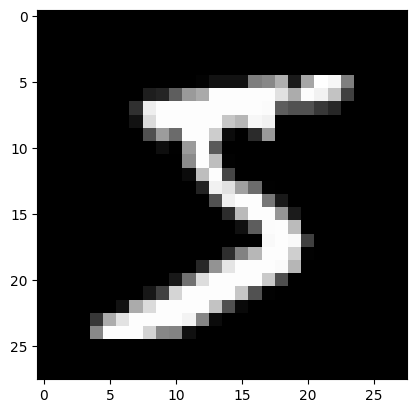

In [ ]:
import matplotlib.pyplot as plt

print(f"x.shape: {train_dataset.__getitem__(0)[0].shape}")
print(f"label: {train_dataset.__getitem__(0)[1]}")
plt.imshow(train_dataset.__getitem__(0)[0].squeeze(), cmap="gray")

### 1.1. Prepare dataset

Let's prepare the dataset using **torch.tuils.data.Dataloader**

PyTorch provides DataLoader for the input data (training/testing) that will be fed into the model when training/testing the model.

**Exercise**: Implement the function below to prepare the training/testing data. You can define the number of examples for the moment and shuffle the order of examples by setting batch_size and shuffle.

**The constructor arguments of a DataLoader :**
```python
torch.utils.data.DataLoader (dataset, batch_size=1, shuffle=False, sampler=None,
                            batch_sampler=None, num_workers=0, collate_fn=None,
                            pin_memory=False, drop_last=False, timeout=0,
                            worker_init_fn=None)
```

In [ ]:
### Set the batch_size
batch_size = 64

### START CODE HERE ### (≈1 lines)
#Use torch.utils.data.DataLoader() with bath_size 64, shuffle = True
train_loader = torch.utils.data.DataLoader( dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
### ENd CODE HERE ###

test_loader = torch.utils.data.DataLoader( dataset=test_dataset,
                                          batch_size = batch_size,
                                          shuffle=False)

# train_loader has (x, y) where x.size()=[64, 1, 28, 28] and y.size()=[64]

### 1.2. Forward propagation

In PyTorch, there are built-in functions that carry out the convolution steps for you.

- **torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):** Applies a 2D convolution over an input signal composed of several input planes.  

- **torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):** applies a 2D max pooling over an input signal composed of several input planes.

- **torch.nn.Linear(in_features, out_features, bias=True):** Applies a linear transformation to the incoming data

- **torch.nn.functional.relu(input, inplace=False):** Applies the rectified linear unit function element-wise

- **torch.nn.functional.softmax(dim=None):** torch.nn.functional.softmax(input, dim=None, _stacklevel=3, dtype=None)

- **torch.flatten(input, start_dim=0, end_dim=-1) :** Flattens a contiguous range of dims in a tensor.

**For more details:**

torch.nn : https://pytorch.org/docs/stable/nn.html

torch.functional : https://pytorch.org/docs/stable/nn.functional.html

torch.flatten : https://pytorch.org/docs/master/generated/torch.flatten.html


**Exercise**:

Implement the `NNModel` class below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. You should use the functions above.


In [ ]:
"""
Implements forward propabation for the CNN model:
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

"""
class NNModel(torch.nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=(2,2)) # input channel, output channels, and filter size
        self.pool1 = nn.MaxPool2d(2, stride=2)

        ### START CODE HERE ###
        # Define the Convolution layer(Condv2d) with (32:input channel, 64:output channels, 5: filter size) and the 2 padding.
        self.conv2 = nn.Conv2d(32, 64, 5, padding=(2,2))
        # Define the Maxpooling layer(MaxPool2d) with (2:filter size, 2:stride)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # Define the fully-conneted layer(Linear) with (3136:input features, 1024:output features)
        self.fc1 = nn.Linear(3136,1024)
        ### END CODE HERE ###
        self.fc2 = nn.Linear(1024,10)

    def forward(self, x):
        """
            Arguments:
            X -- input dataset placeholder, of shape (input size, number of examples)
            parameters -- python dictionary containing your parameters "W1", "W2"
                          the shapes are given in initialize_parameters

            Returns:
            F.softmax(x) -- the softmax output of the last LINEAR unit
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        ### START CODE HERE ###
        # Load sceond Convoultion layer(conv2d)
        x = self.conv2(x)
        # Load Relu function
        x = F.relu(x)
        # Load sceond Maxpooling layer(MaxPool2d)
        x = self.pool2(x)
        # Flatten each example into a 1D vector: (?,7,7,64)->(?, 3136)
        x = torch.flatten(x, 1)
        # Load first fully-connted layer
        x = self.fc1(x)
        ### END CODE HERE ###
        x = F.relu(x)
        x = self.fc2(x)
        return x
#        return F.softmax(x, dim=1)


In [ ]:
random_seed = 0
torch.manual_seed(random_seed)

temp_model = NNModel()

def weights_init_for_test(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    torch.nn.init.zeros_(m.weight)
    torch.nn.init.zeros_(m.bias)

temp_model.apply(weights_init_for_test)

temp_in = train_dataset.__getitem__(0)[0]
temp_out = temp_model(temp_in.unsqueeze(0))
print(temp_out)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward0>)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=\<AddmmBackward0\>)

### 1.3. Build model

Finally you will merge the helper functions you implemented above to build and train a model.  

**Exercise**: Complete the function below.

The model below should:

- Define the cost function with **torch.nn.CrossEntropyLoss()**    
> torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
> **For more details:** https://pytorch.org/docs/stable/nn.html

- Create optmizization function with **torch.optim.SGD()**
> torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)     
> **For more details:** https://pytorch.org/docs/stable/optim.html
- hint : For getting params for optmizer, use the following code
```python
params = model.parameters()
```


In [ ]:
model = NNModel()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)

### START CODE HERE ###
# Define the cost function with cross entropy
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
# Create optimizer
# Get model paramters
params = model.parameters()
# Define the optimizer (using SGD) with learing rate=0.01 and momentum=0.5
optimizer = optim.SGD(params, lr=0.01, momentum=0.5)
### END CODE HERE ###

model = model.to(device)


## 2. Train and test model

Finally you will create training and testing function with a loop for each mini-batch.


### 2.1 Train function

Implement the function to train the CNN model.

**Exercise**: Complete the function below.

- copy a tensor on the CPU to the GPU
- call the CNN model
- initialize the optimizer  
- compute the cost  
- compute the backward propagation
- update parameters with the optimizer

**Hint**
- copy a tensor on the CPU to the GPU
         # copy a tensor to the CPU
         data = data.to("cpu")
         # copy a tensor to the GPU
         data = data.to("cuda")
- call the CNN model : call the predefined CNN model funciton    
- initialize optimizer
        optimizer.zero_grad()
- compute the cost : call the predifined criterion function  
- compute the backward propagation   
        loss.backward()
- update parameters with the optimizer
        optimizer.step()





In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        ### START CODE HERE ###
        # Copy "data" tensor to the GPU
        data = data.to(device)
        # Copy "target" tensor to the GPU
        target = target.to(device)
        # Call model function and input the data tensor
        output = model(data)
        # Initialize the optimizer
        optimizer.zero_grad()
        # Compute the cost
        loss = criterion(output, target)
        # Compute the back-prop
        loss.backward()
        # Update prameters with the optmizer
        optimizer.step()
        ### END CODE HERE ###
        if batch_idx%100==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx*len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss))

### 2.2 Test function

In [ ]:
def test():
    model.eval()
    with torch.no_grad():
        test_loss=0
        correct = 0
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output,target)
            pred = output.data.max(1,keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /=len(train_loader.dataset)
        print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct,
            len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))

        test_loss=0
        correct = 0
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output,target)
            pred = output.data.max(1,keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /=len(test_loader.dataset)
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


### 2.3. Run the train/test function

Run the following cell to train and test your model for 100 epochs.  

In [ ]:
for epoch in range(0,100):
    train(epoch)
    if epoch%100==0:
        test()
test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302463
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.260412
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.687199
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.505515
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.468251
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.293451
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.296168
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.184634
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.198093
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.194800
Train set: Average loss: 0.0031, Accuracy: 56333/60000 (94%)
Test set: Average loss: 0.0028, Accuracy: 9418/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.169697
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.562916
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.135246
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.138963
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.078383
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.054550
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.267101
Train Epoch: 1 [44800/60000 (75%)]	Loss: 